# GAN 

# Omani 

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

class CovidDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data.values)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, output_dim),
            nn.Sigmoid()  # Use Sigmoid to output values between 0 and 1
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def train_gan(data_path, num_epochs=500, batch_size=32, latent_dim=200):
    # Load and prepare data
    df = pd.read_csv(data_path)

    # Convert all columns to numeric, forcing errors to NaN
    df = df.apply(pd.to_numeric, errors='coerce')

    # Drop rows with NaN values
    df = df.dropna()

    # Normalize the data
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    dataset = CovidDataset(df_scaled)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    generator = Generator(latent_dim, len(df.columns))
    discriminator = Discriminator(len(df.columns))

    criterion = nn.BCELoss()
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        batches = 0

        for i, real_data in enumerate(dataloader):
            batch_size = real_data.size(0)
            batches += 1

            # Train Discriminator
            d_optimizer.zero_grad()
            label_real = torch.ones(batch_size, 1)
            label_fake = torch.zeros(batch_size, 1)

            z = torch.randn(batch_size, latent_dim)
            fake_data = generator(z)

            d_loss_real = criterion(discriminator(real_data), label_real)
            d_loss_fake = criterion(discriminator(fake_data.detach()), label_fake)
            d_loss = d_loss_real + d_loss_fake

            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            z = torch.randn(batch_size, latent_dim)
            fake_data = generator(z)
            g_loss = criterion(discriminator(fake_data), label_real)
            g_loss.backward()
            g_optimizer.step()

            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

        avg_g_loss = epoch_g_loss / batches
        avg_d_loss = epoch_d_loss / batches

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {avg_d_loss:.4f}, g_loss: {avg_g_loss:.4f}')

    return generator, scaler

def generate_samples(generator, scaler, num_samples=100, latent_dim=200):
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        generated_data = generator(z).numpy()

    # Inverse transform the generated data
    df_generated = pd.DataFrame(scaler.inverse_transform(generated_data), columns=scaler.feature_names_in_)

    # Round the generated data to get binary values (0 or 1)
    df_generated = df_generated.round().clip(0, 1)  # Ensure values are either 0 or 1
    return df_generated

def main():
    data_path = 'encoded_data.csv'  # Update this path

    generator, scaler = train_gan(data_path, num_epochs=100, latent_dim=200)

    original_data = pd.read_csv(data_path)

    # Generate synthetic samples
    synthetic_data = generate_samples(generator, scaler, num_samples=20000)  # Increase the number of samples

    # Ensure the synthetic data has the same columns as the original data
    synthetic_data.columns = original_data.columns

    # Add source column
    original_data['data_source'] = 'original'
    synthetic_data['data_source'] = 'synthetic'

    # Merge datasets
    merged_data = pd.concat([original_data, synthetic_data], axis=0, ignore_index=True)

    # Save datasets
    synthetic_data.to_csv('synthetic_covid_data.csv', index=False)
    merged_data.to_csv('merged_covid_data.csv', index=False)

    print("Synthetic and merged datasets have been saved.")

if __name__ == "__main__": 
    main()

Epoch [10/100], d_loss: 0.3770, g_loss: 3.0416
Epoch [20/100], d_loss: 0.2656, g_loss: 4.1275
Epoch [30/100], d_loss: 0.2642, g_loss: 4.7423
Epoch [40/100], d_loss: 0.1993, g_loss: 5.3193
Epoch [50/100], d_loss: 0.2050, g_loss: 5.7866
Epoch [60/100], d_loss: 0.1557, g_loss: 6.3521
Epoch [70/100], d_loss: 0.1675, g_loss: 6.4343
Epoch [80/100], d_loss: 0.1745, g_loss: 6.7328
Epoch [90/100], d_loss: 0.1348, g_loss: 7.1126
Epoch [100/100], d_loss: 0.1672, g_loss: 7.2631
Synthetic and merged datasets have been saved.


In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

class CovidDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data.values)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, output_dim),
            nn.Sigmoid()  # Use Sigmoid to output values between 0 and 1
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def train_gan(data_path, num_epochs=500, batch_size=32, latent_dim=200):
    # Load and prepare data
    df = pd.read_csv(data_path)

    # Convert all columns to numeric, forcing errors to NaN
    df = df.apply(pd.to_numeric, errors='coerce')

    # Drop rows with NaN values
    df = df.dropna()

    # Normalize the data
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    dataset = CovidDataset(df_scaled)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    generator = Generator(latent_dim, len(df.columns))
    discriminator = Discriminator(len(df.columns))

    criterion = nn.BCELoss()
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        batches = 0

        for i, real_data in enumerate(dataloader):
            batch_size = real_data.size(0)
            batches += 1

            # Train Discriminator
            d_optimizer.zero_grad()
            label_real = torch.ones(batch_size, 1)
            label_fake = torch.zeros(batch_size, 1)

            z = torch.randn(batch_size, latent_dim)
            fake_data = generator(z)

            d_loss_real = criterion(discriminator(real_data), label_real)
            d_loss_fake = criterion(discriminator(fake_data.detach()), label_fake)
            d_loss = d_loss_real + d_loss_fake

            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            z = torch.randn(batch_size, latent_dim)
            fake_data = generator(z)
            g_loss = criterion(discriminator(fake_data), label_real)
            g_loss.backward()
            g_optimizer.step()

            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

        avg_g_loss = epoch_g_loss / batches
        avg_d_loss = epoch_d_loss / batches

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {avg_d_loss:.4f}, g_loss: {avg_g_loss:.4f}')

    return generator, scaler

def generate_samples(generator, scaler, num_samples=100, latent_dim=200):
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        generated_data = generator(z).numpy()

    # Inverse transform the generated data
    df_generated = pd.DataFrame(scaler.inverse_transform(generated_data), columns=scaler.feature_names_in_)

    # Round the generated data to get binary values (0 or 1)
    df_generated = df_generated.round().clip(0, 1)  # Ensure values are either 0 or 1
    return df_generated

def main():
    data_path = '/Users/ishaanpothapragada/Desktop/Desktop_Documents/Maize/encoded_data.csv'  # Update this path

    generator, scaler = train_gan(data_path, num_epochs=500, latent_dim=200)

    original_data = pd.read_csv(data_path)

    # Generate synthetic samples
    synthetic_data = generate_samples(generator, scaler, num_samples=20000)  # Increase the number of samples

    # Ensure the synthetic data has the same columns as the original data
    synthetic_data.columns = original_data.columns

    # Add source column
    original_data['data_source'] = 'original'
    synthetic_data['data_source'] = 'synthetic'

    # Merge datasets
    merged_data = pd.concat([original_data, synthetic_data], axis=0, ignore_index=True)

    # Save datasets
    synthetic_data.to_csv('synthetic500_covid_data.csv', index=False)
    merged_data.to_csv('merged500_covid_data.csv', index=False)

    print("Synthetic and merged datasets have been saved.")

if __name__ == "__main__": 
    main()

Epoch [10/500], d_loss: 0.3243, g_loss: 3.1780
Epoch [20/500], d_loss: 0.2469, g_loss: 4.1939
Epoch [30/500], d_loss: 0.2082, g_loss: 4.8698
Epoch [40/500], d_loss: 0.2159, g_loss: 5.3772
Epoch [50/500], d_loss: 0.1933, g_loss: 5.6572
Epoch [60/500], d_loss: 0.1661, g_loss: 5.9893
Epoch [70/500], d_loss: 0.1820, g_loss: 6.2154
Epoch [80/500], d_loss: 0.1886, g_loss: 6.3766
Epoch [90/500], d_loss: 0.1538, g_loss: 6.5437
Epoch [100/500], d_loss: 0.1545, g_loss: 6.8914
Epoch [110/500], d_loss: 0.1511, g_loss: 7.0539
Epoch [120/500], d_loss: 0.1336, g_loss: 7.2160
Epoch [130/500], d_loss: 0.1227, g_loss: 7.6821
Epoch [140/500], d_loss: 0.1655, g_loss: 7.5786
Epoch [150/500], d_loss: 0.1372, g_loss: 7.5691
Epoch [160/500], d_loss: 0.1371, g_loss: 7.4432
Epoch [170/500], d_loss: 0.1527, g_loss: 7.4989
Epoch [180/500], d_loss: 0.1371, g_loss: 7.4689
Epoch [190/500], d_loss: 0.1530, g_loss: 7.4179
Epoch [200/500], d_loss: 0.1762, g_loss: 7.2799
Epoch [210/500], d_loss: 0.1370, g_loss: 7.0361
E

<H1>OUTLIER AND SMOTE BALANCING</H1>

Total number of samples before outlier removal: 25434


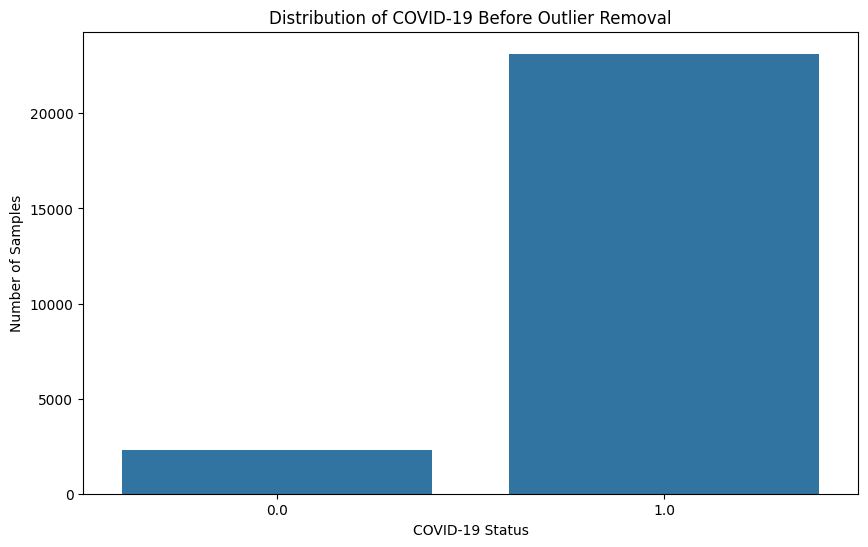

Total number of samples after outlier removal: 25434


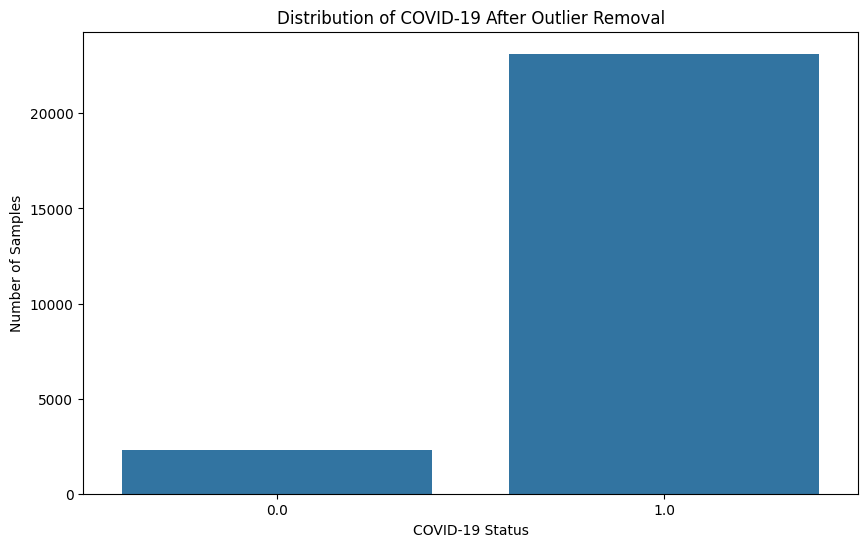

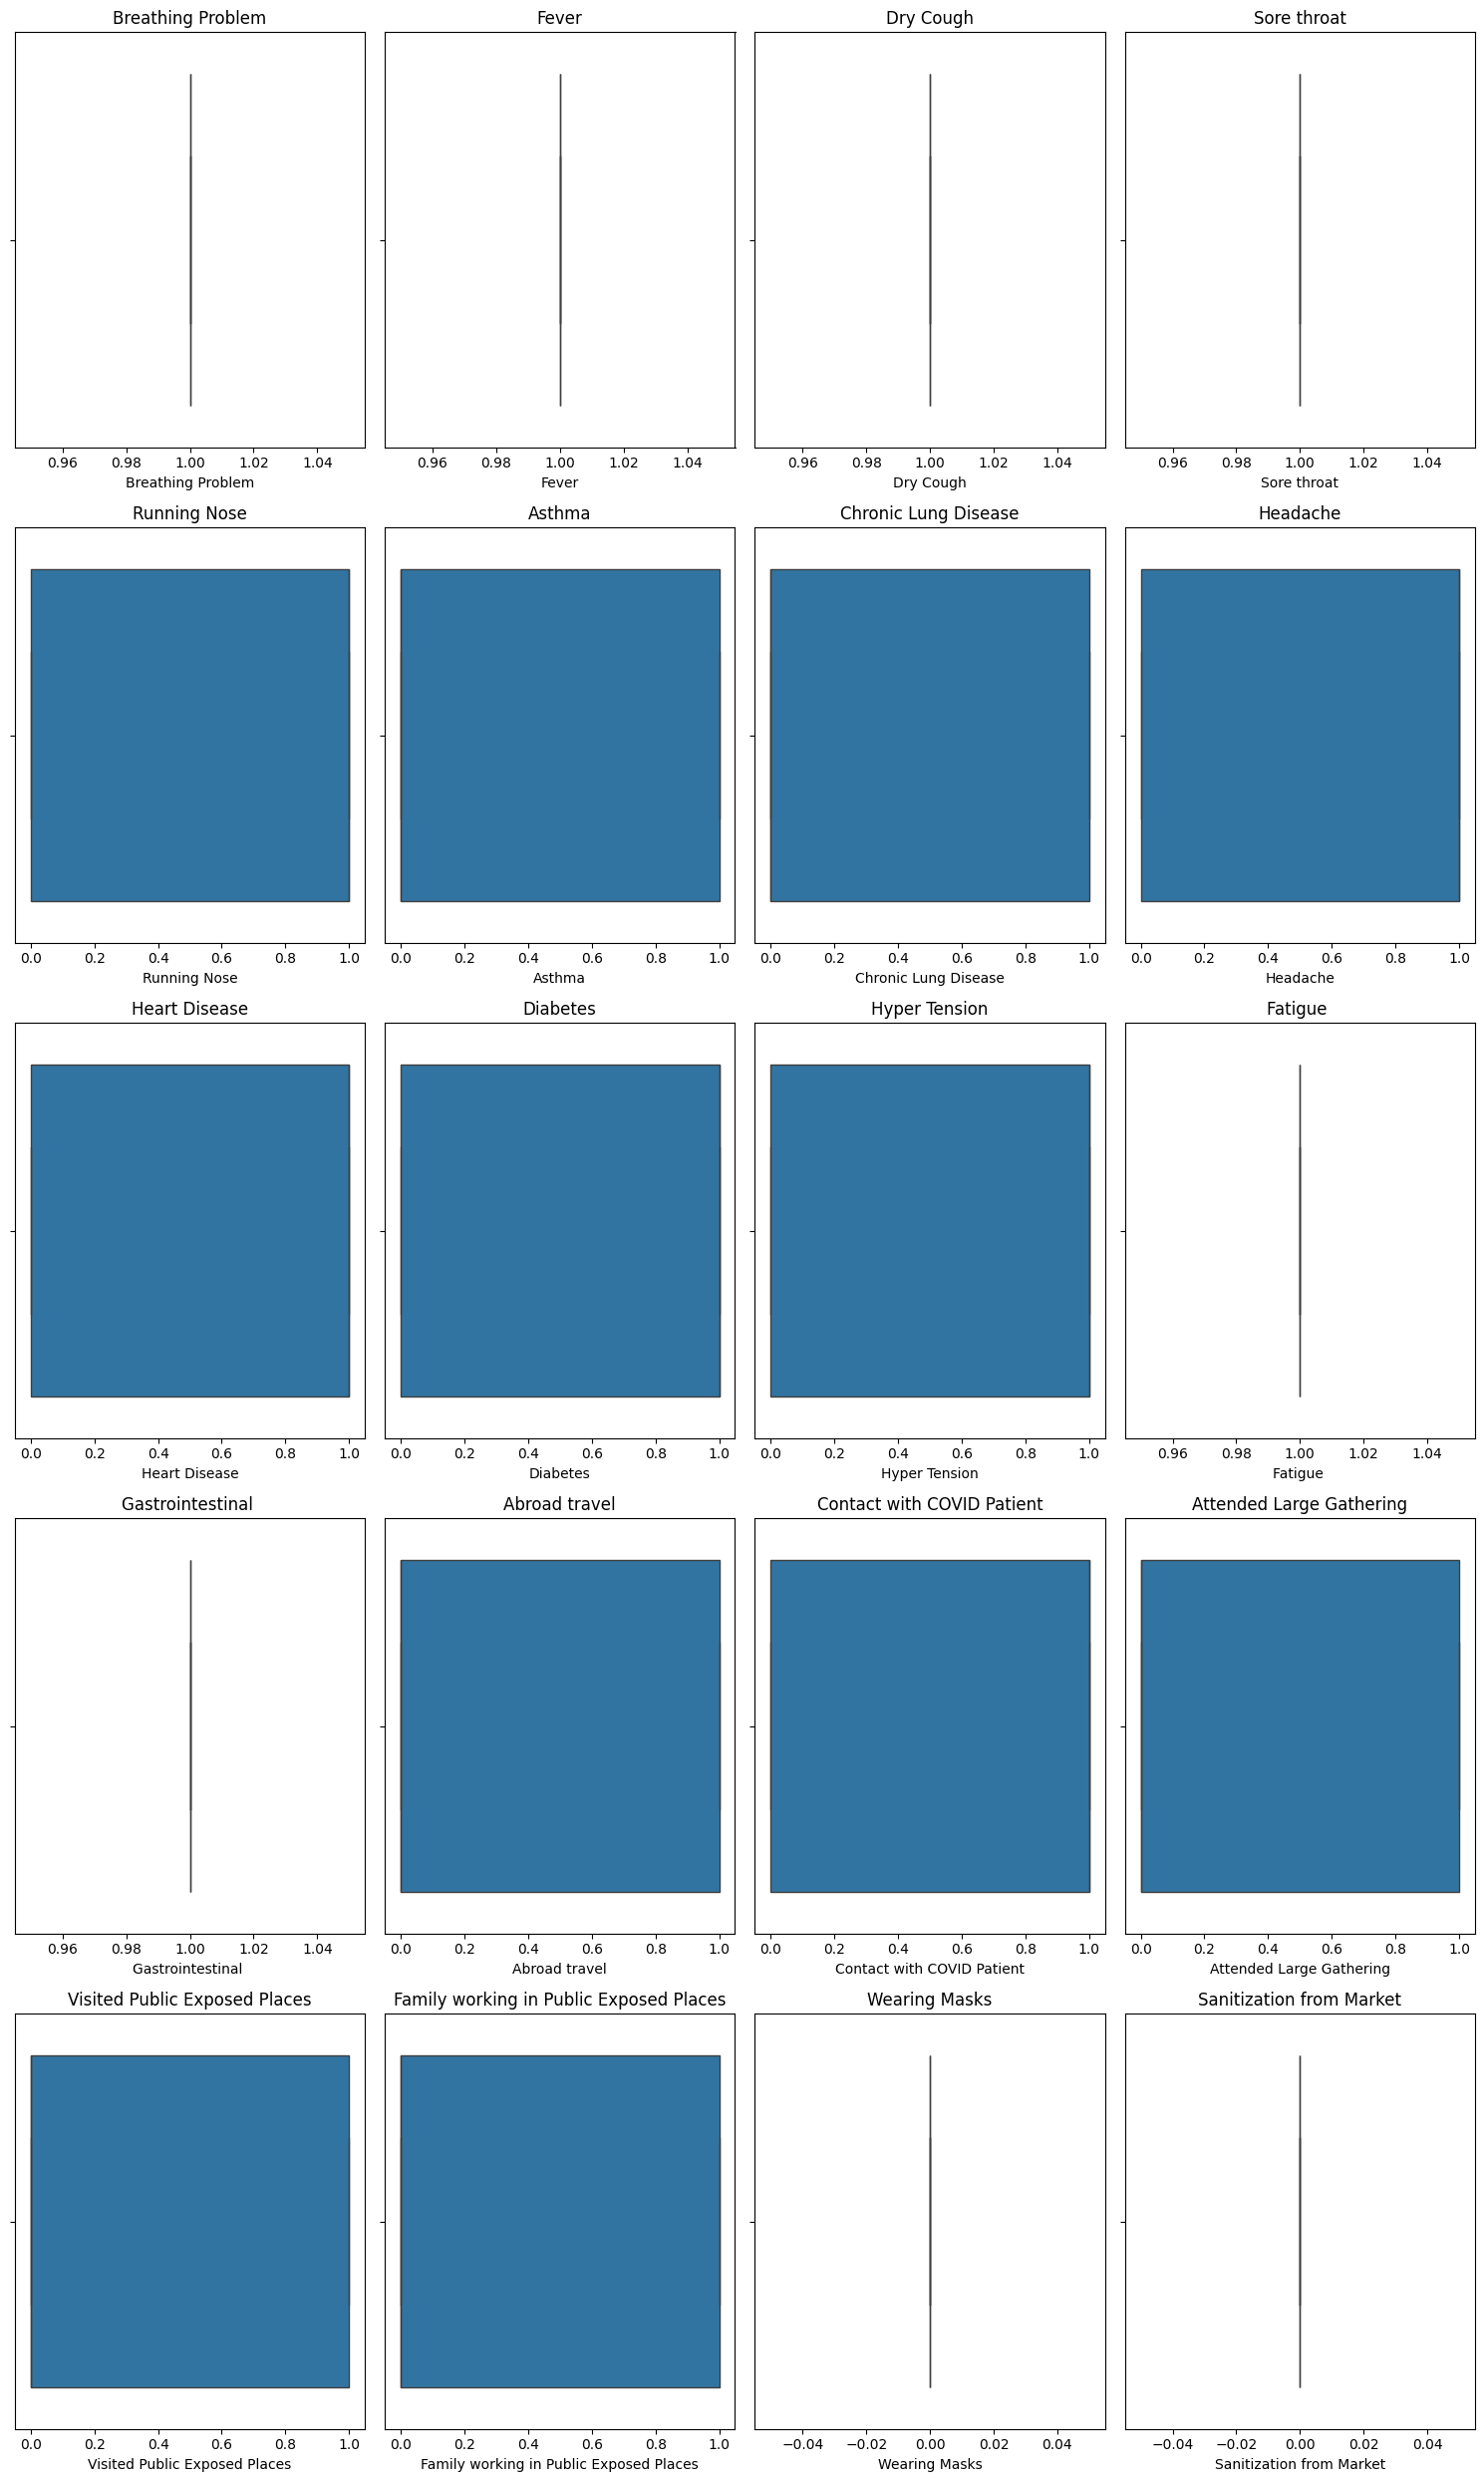

Total number of samples after SMOTE: 46270


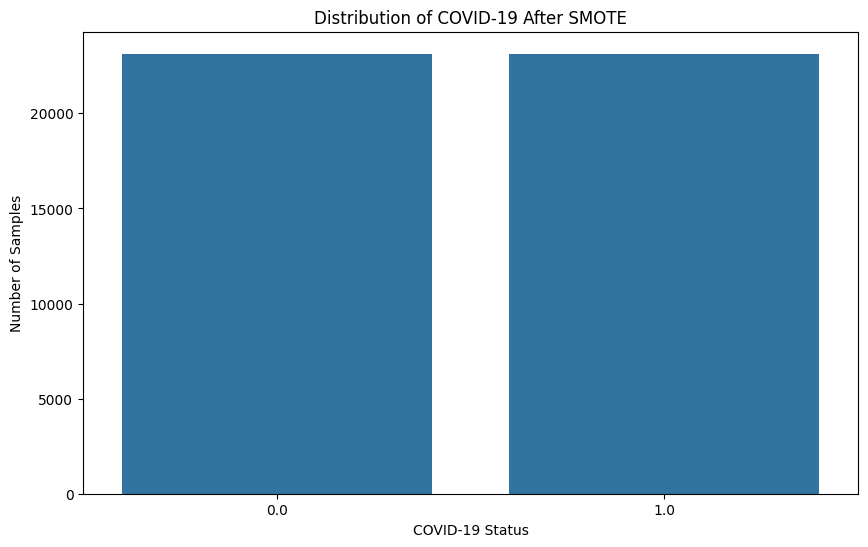

Preprocessed dataset saved as 'preprocessed_covid500.csv'.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

def preprocess_data(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)

    # Drop the 'data_source' column
    df.drop(columns=['data_source'], inplace=True)

    # Define the target variable and features
    X = df.drop(columns=['COVID-19'])
    y = df['COVID-19']

    # Function to visualize distribution
    def visualize_distribution(data, title):
        plt.figure(figsize=(10, 6))
        sns.countplot(x=data)
        plt.title(title)
        plt.xlabel('COVID-19 Status')
        plt.ylabel('Number of Samples')
        plt.show()

    # Print the number of samples before outlier removal
    print(f"Total number of samples before outlier removal: {len(df)}")
    visualize_distribution(y, 'Distribution of COVID-19 Before Outlier Removal')

    # IQR-based outlier removal
    def remove_outliers_iqr(data):
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        return data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))]

    # Apply IQR outlier removal to each feature
    for column in X.columns:
        X[column] = remove_outliers_iqr(X[column])

    # Handle missing values after outlier removal
    X.fillna(X.median(), inplace=True)

    # Print the number of samples after outlier removal
    print(f"Total number of samples after outlier removal: {X.shape[0]}")
    visualize_distribution(y, 'Distribution of COVID-19 After Outlier Removal')

    # Visualize boxplots for each feature after outlier removal
    num_features = X.shape[1]
    cols = 4  # Number of columns for the subplot
    rows = (num_features + cols - 1) // cols  # Calculate number of rows needed

    plt.figure(figsize=(15, 5 * rows))
    for i, column in enumerate(X.columns):
        plt.subplot(rows, cols, i + 1)
        sns.boxplot(x=X[column])
        plt.title(column)
    plt.tight_layout()
    plt.show()

    # Perform SMOTE for data balancing
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Print the number of samples after SMOTE
    print(f"Total number of samples after SMOTE: {X_resampled.shape[0]}")
    visualize_distribution(y_resampled, 'Distribution of COVID-19 After SMOTE')

    # Combine the features and target back into a single DataFrame
    preprocessed_df = pd.DataFrame(X_resampled, columns=X.columns)
    preprocessed_df['COVID-19'] = y_resampled

    # Save the preprocessed dataset to a CSV file
    preprocessed_df.to_csv('preprocessed_covid500.csv', index=False)
    print("Preprocessed dataset saved as 'preprocessed_covid500.csv'.")

    # Return the processed features and target
    return X_resampled, y_resampled

# Example usage
file_path = 'merged500_covid_data.csv'  # Replace with your dataset path
X_processed, y_processed = preprocess_data(file_path)